## Information

GitHub: https://github.com/ExMechE

In [1]:
from google.colab import files
#kaggle.json
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c histopathologic-cancer-detection
import zipfile

with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/histopathologic_dataset')

100% 6.28G/6.31G [00:50<00:00, 259MB/s]
100% 6.31G/6.31G [00:50<00:00, 133MB/s]


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from fastai.vision import *
from fastai.vision.all import *
from torchvision.models import *

import torch
import torch.nn as nn

from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Brief description of the problem and data

This assignment is based on a past Kaggle competition which encourages users to create an algorithm to identify metastatic cancer based on images generated by digital pathology scans. The data used is a modified version of PCam (PatchCamelyon) data which allows for simpler analysis as the results are binary and similar to CIFAR-10 and MNIST

As for the data samples are split between a training and test dataset. The training set has a known set of labels that will aid in classification and model learning. The training set consists of 176,020 samples. The testing set consists of 57,458 samples. Each sample is an image that if it is cancerous will have at least one pixel of tumor tissue in the center 32x32px region. Tumor tissue anywhere else will not impact the results. The training and test data have two columns. One contains the name of the image file corresponding to an image found in a separate folder. The other contains the binary label of 0 or 1. 1 indicates the presence of a tumor and 0 indicated negative. 

In [33]:
df_new = pd.read_csv('/content/histopathologic_dataset/train_labels.csv')
df_new.head()
data = ImageDataLoaders.from_df(df_new, folder = '/content/histopathologic_dataset/train', suff = '.tif', size=48,bs=32);

## Exploratory data analysis

Below is a histogram that shows the breakdown of the classification data. There are roughly 130000 negative samples and 90000 positive samples.

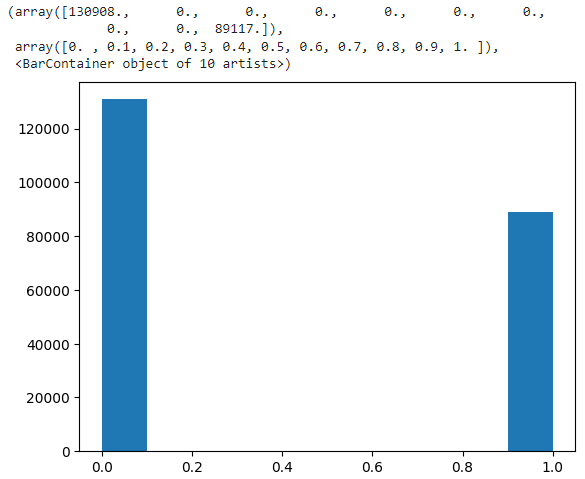

In [ ]:
plt.hist(df_new['label'])

In [35]:
def auc(p,true):
    return roc_auc_score(true,torch.sigmoid(p)[:,1])

## Model Architecture

Fastai is a library incorporating deep learning with low level components. It is able to process image data at several layers of abstractions. ImageDataLoader breaks down the images into bite sized data chunks which can be adjusted via rotation, scaling, among other actions to reveal other potential trends. This along with the ability to quickly customize validation and testing sets enable effective data processing in just a few lines of code. Here, area under the curve is used as the primary metric to assess the effectiveness of the model.

In [38]:
learn = cnn_learner(data, densenet201, metrics = [auc], path = '/content/histopathologic_dataset/', ps = 0.4)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 96.8MB/s]


SuggestedLRs(valley=0.0010000000474974513)

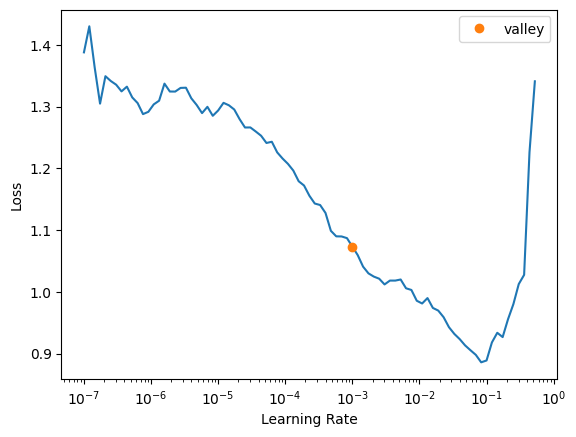

In [40]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(1,2e-03)

epoch,train_loss,valid_loss,auc_score,time
0,0.134863,0.117685,0.976692,7:59:03


## Results

As shown above and below, the AUC score is extremely high after a cycle. Also, using both tta and without lead to close success rates.

In [45]:
p,act = learn.get_preds()
score = auc_score(p,act)
score

tensor(0.9901)

In [47]:
p_tta,act_tta = learn.tta()
score_tta = auc_score(p_tta,act_tta)
score_tta

tensor(0.9901)

In [ ]:
test_p,y = learn.get_preds(ds_type=DatasetType.Test)

In [62]:
submission = pd.read_csv('/content/histopathologic_dataset/sample_submission.csv')

In [63]:
clean_f = np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
cleaned_f = clean_f(data).astype(str)

In [ ]:
submission.loc[cleaned_f,'label'] = to_np(test_p[:,1])
submission.to_csv('submission.csv')

## Conclusion

From the model that was generated here and after a couple iterations of batch sizing, the results yielded on Kaggle were 49.98% This leads me to conclude that my model overfit the data which tends to lead to poorer performance in test data. If I had more time to complete this project I would have adjusted the hyperparameters and learning rate more to optimize the results.

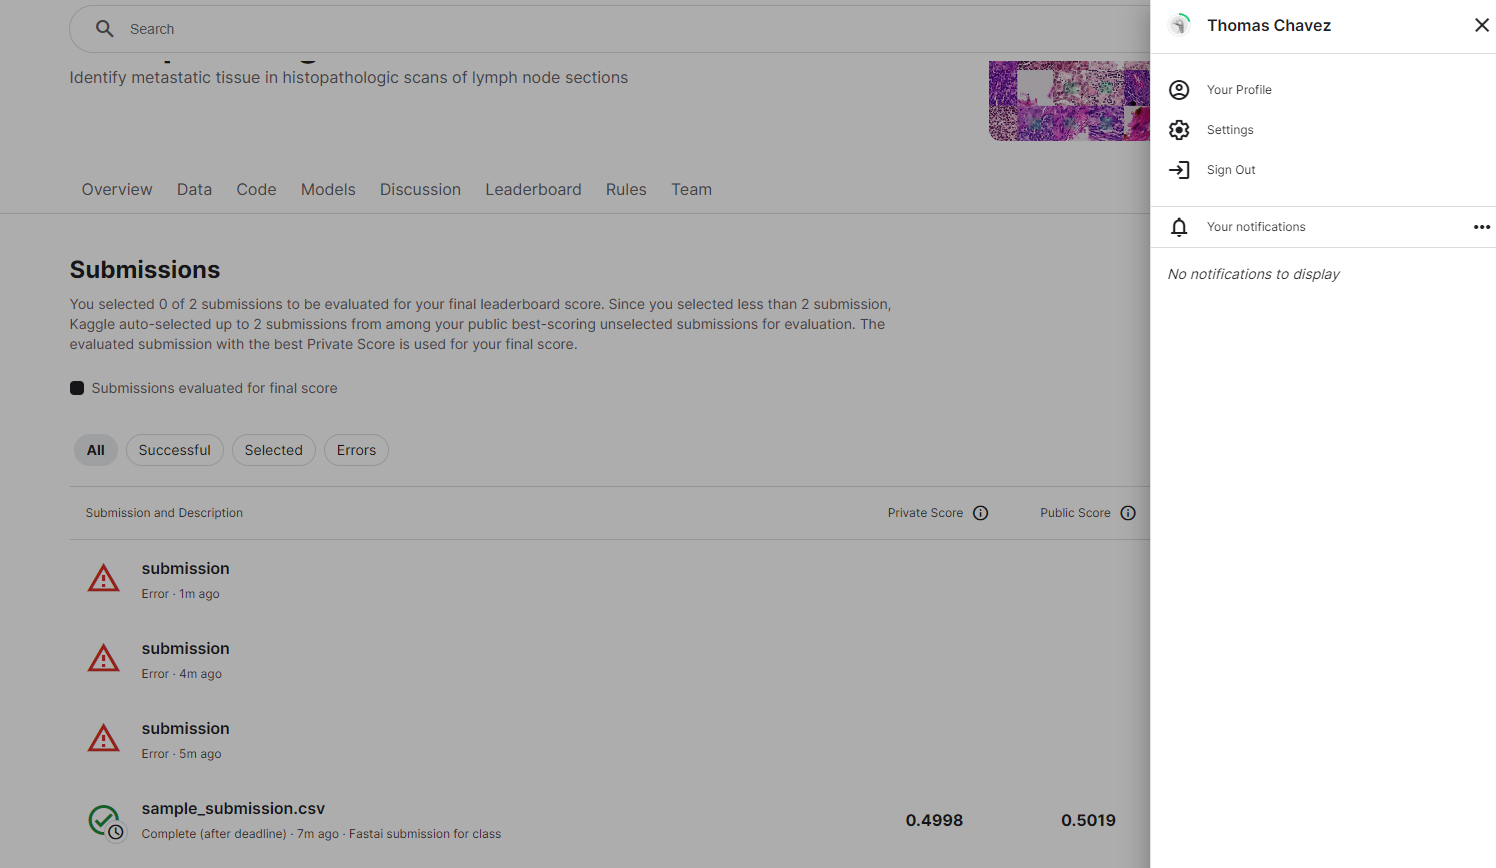

In [2]:
from IPython.display import Image
Image(filename='Kaggle Leaderboard.png') 